In [ ]:
Oracle AI Data Platform v1.0

Copyright © 2025, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

# Analyze Data Using PySpark Examples

 **Learn basic PySpark features in AI Data Platform**

 See https://spark.apache.org/docs/latest/api/python/index.html for detailed documentation.
 
 This notebook demonstrates different ways to read and write data from tables in AI Data Platform. It covers:
 
 1. **Setup catalog and schemas**
 2. **Create Table**
 3. **Table operations**
    - Insert data
 4. **Schema exploration**
    - Listing schemas and tables
 5. **Visualize data using matplotlib**

  **Prerequisites**

  Install requirements.txt which contains matplotlib into the cluster before running the notebook.

# **1. Setup catalog and schemas**

## Show Catalogs

In [1]:
%sql
show catalogs

## Create Managed Catalog

In [1]:
%sql
create catalog if not exists lake

In [1]:
# Describe Catalog
spark.sql("describe catalog lake").show()

+------------------+--------------------+
| attribute| attribute_value|
+------------------+--------------------+
| name| lake|
| createdOn| 1742755977633|
| updatedOn| 1742755977275|
|connection_details| {}|
| catalog_details|{"createdOn":"174...|
| createdBy|ocid1.user.oc1..a...|
| type| INTERNAL|
| updatedBy|ocid1.user.oc1..a...|
+------------------+--------------------+

## Create Schema in Managed Catalog

In [1]:
%sql
create schema if not exists lake.bronze

OK

In [1]:
# Describe Schema
spark.sql("describe schema lake.bronze").show()

+--------------+----------+
| info_name|info_value|
+--------------+----------+
| Catalog Name| lake|
|Namespace Name| bronze|
+--------------+----------+

# **2. Create Table**

## Create Managed Table
Default managed table is created in Parquet format.

In [1]:
# Sample patient data
data = [
    ("2025-03-24T08:00:00Z", "P001", 72, "120/80", 98, 36.8, "302A", "stable"),
    ("2025-03-24T08:05:00Z", "P001", 75, "118/78", 97, 36.9, "302A", "stable"),
    ("2025-03-24T08:10:00Z", "P002", 90, "140/90", 92, 38.2, "215B", "critical"),
    ("2025-03-24T08:15:00Z", "P002", 95, "145/95", 90, 38.5, "215B", "critical")
]

columns = ["timestamp", "patient_id", "heart_rate_bpm", "blood_pressure", "oxygen_saturation", "temperature_C", "room_number", "status"]

df = spark.createDataFrame(data, columns)
df.write.mode("overwrite").saveAsTable("lake.bronze.patient_data_tab")

# **3. Table Operations**

# Insert Data in Table

In [1]:
data = [
    ("2025-03-24T08:20:00Z", "P003", 93, "143/95", 91, 37.5, "215B", "critical")
]

columns = ["timestamp", "patient_id", "heart_rate_bpm", "blood_pressure", "oxygen_saturation", "temperature_C", "room_number", "status"]

df = spark.createDataFrame(data, columns)
df.write.insertInto("lake.bronze.patient_data_tab")


## Query Data

In [1]:
# Query managed table
spark.sql("select * from lake.bronze.patient_data_tab").show()

+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
| timestamp|patient_id|heart_rate_bpm|blood_pressure|oxygen_saturation|temperature_C|room_number| status|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+
|2025-03-24T08:10:00Z| P002| 90| 140/90| 92| 38.2| 215B|critical|
|2025-03-24T08:15:00Z| P002| 95| 145/95| 90| 38.5| 215B|critical|
|2025-03-24T08:00:00Z| P001| 72| 120/80| 98| 36.8| 302A| stable|
|2025-03-24T08:05:00Z| P001| 75| 118/78| 97| 36.9| 302A| stable|
|2025-03-24T08:20:00Z| P003| 93| 143/95| 91| 37.5| 215B|critical|
+--------------------+----------+--------------+--------------+-----------------+-------------+-----------+--------+

# **4. Schema Exploration**

## Show Schemas, Tables, Describe Tables

In [1]:
spark.sql("show schemas in lake").show()

+---------+
|namespace|
+---------+
| default|
| bronze|
+---------+

In [1]:
spark.sql("show tables in lake.bronze").show()

+---------+----------------+-----------+
|namespace| tableName|isTemporary|
+---------+----------------+-----------+
| bronze|patient_data_tab| false|
+---------+----------------+-----------+

In [1]:
# List tables using a pattern eg. tables beginning with e
spark.sql("show tables in lake.bronze like 'p.*'").show()

+---------+----------------+-----------+
|namespace| tableName|isTemporary|
+---------+----------------+-----------+
| bronze|patient_data_tab| false|
+---------+----------------+-----------+

In [1]:
# Describe managed table, see type is MANAGED and provider is parquet
spark.sql("describe table extended lake.bronze.patient_data_tab").show()

+--------------------+--------------------+-------+
| col_name| data_type|comment|
+--------------------+--------------------+-------+
| timestamp| string| NULL|
| patient_id| string| NULL|
| heart_rate_bpm| bigint| NULL|
| blood_pressure| string| NULL|
| oxygen_saturation| bigint| NULL|
| temperature_C| double| NULL|
| room_number| string| NULL|
| status| string| NULL|
| | | |
|# Detailed Table ...| | |
| Name|bronze.patient_da...| |
| Type| MANAGED| |
| Location|oci://t7q7elmpr2y...| |
| Provider| parquet| |
| Owner|ocid1.user.oc1..a...| |
| Is_managed_location| true| |
| Table Properties|[com.oracle.dcat....| |
+--------------------+--------------------+-------+

# List all tables in all schemas in a catalog

In [1]:
catalog_name="lake"
databases = [
    catalog_name+"."+db.namespace 
    for db in spark.sql('show schemas in '+catalog_name).collect()
]
tables = [
    catalog_name+"."+f"{row['namespace']}.{row['tableName']}" #<catalog>.<schema>.<table> format
    for db_rows in [
        spark.sql(f'show tables in {db}').collect() for db in databases
    ] 
    for row in db_rows
]
print(tables)

["lake.bronze.patient_data_tab"]

# Visualize Data using Matplotlib


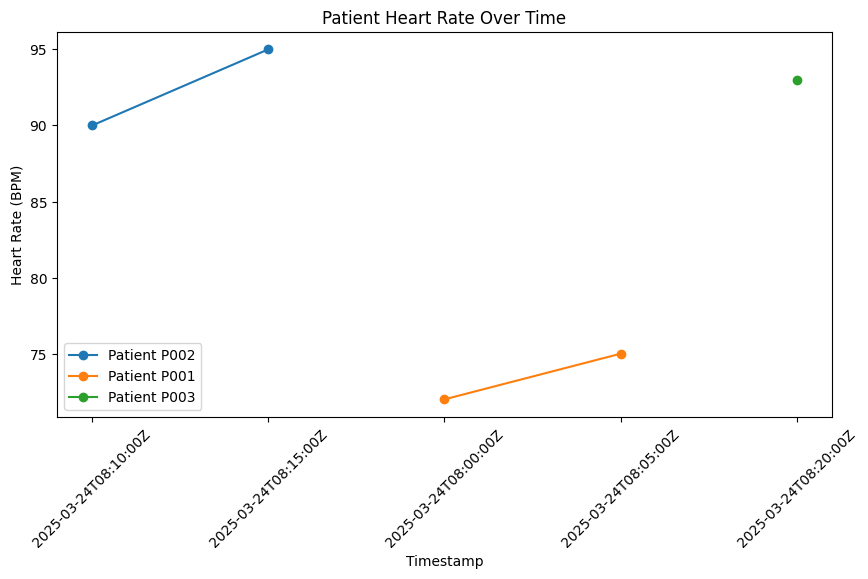

In [1]:
import matplotlib.pyplot as plt

# Convert Delta Table to Pandas
deltaTable = spark.sql("select * from lake.bronze.patient_data_tab")
df_pandas = deltaTable.toPandas()

# Plot
plt.figure(figsize=(10,5))
for patient in df_pandas["patient_id"].unique():
    patient_data = df_pandas[df_pandas["patient_id"] == patient]
    plt.plot(patient_data["timestamp"], patient_data["heart_rate_bpm"], marker='o', label=f"Patient {patient}")

plt.xlabel("Timestamp")
plt.ylabel("Heart Rate (BPM)")
plt.title("Patient Heart Rate Over Time")
plt.legend()
plt.xticks(rotation=45)
plt